# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help yo`u:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 81.7 MB/s eta 0:00:00:00:0100:01


### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [2]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "/kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "unet",
        "kernel_size": 3,
        "init_dim": 32,
        "depth": 6,
        "dropout_rate": 0.3,
    },
    "training": {
        "lr": 5e-5,
    },
    "trainer": {
        "max_epochs": 100,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

INFO: Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [3]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(identity)
        return self.relu(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return self.final(self.dropout(x))


In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.drop = nn.Dropout2d(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.relu2 = nn.ReLU(inplace=True)

        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu1(self.conv1(x))
        out = self.drop(out)
        out = self.conv2(out)
        return self.relu2(out + identity)

class UNet(nn.Module):
    def __init__(
        self,
        n_input_channels,
        n_output_channels,
        kernel_size=3,
        init_dim=64,
        dropout_rate=0.1,
        depth=4,
    ):
        super().__init__()
        self.depth = depth
        self.dims = [init_dim * (2 ** i) for i in range(depth + 1)]

        self.encoders = nn.ModuleList()
        self.downsamples = nn.ModuleList()
        in_ch = n_input_channels
        for i in range(depth):
            self.encoders.append(ConvBlock(in_ch, self.dims[i], kernel_size, dropout_rate))
            self.downsamples.append(
                nn.Conv2d(self.dims[i], self.dims[i], kernel_size=3, stride=2, padding=1)
            )
            in_ch = self.dims[i]

        self.bottleneck = ConvBlock(self.dims[depth - 1], self.dims[depth], kernel_size, dropout_rate)

        self.upconvs = nn.ModuleList()
        self.decoders = nn.ModuleList()
        for i in reversed(range(depth)):
            self.upconvs.append(
                nn.ConvTranspose2d(self.dims[i + 1], self.dims[i], kernel_size=2, stride=2)
            )
            self.decoders.append(
                ConvBlock(self.dims[i] * 2, self.dims[i], kernel_size, dropout_rate)
            )

        self.final = nn.Conv2d(self.dims[0], n_output_channels, kernel_size=1)

    def forward(self, x):
        enc_outputs = []

        for i in range(self.depth):
            x = self.encoders[i](x)
            enc_outputs.append(x)
            x = self.downsamples[i](x)

        x = self.bottleneck(x)

        for i in range(self.depth):
            x = self.upconvs[i](x)

            # Handle odd size mismatches (e.g., due to stride rounding)
            enc = enc_outputs[self.depth - 1 - i]
            if x.shape[-2:] != enc.shape[-2:]:
                x = torch.nn.functional.interpolate(x, size=enc.shape[-2:], mode='bilinear', align_corners=False)

            x = torch.cat([x, enc], dim=1)
            x = self.decoders[i](x)

        return self.final(x)

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [6]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


In [7]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_months=120,
        test_months=360,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_months = val_months
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.val_months:]
                val_output = y[-self.val_months:]
                train_input.append(x[:-self.val_months])
                train_output.append(y[:-self.val_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [8]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss, prog_bar=True)  # Log loss for tracking
        return loss

    def on_train_epoch_end(self):
        loss = self.trainer.callback_metrics.get("train/loss")
        if loss is not None:
            self.train_losses.append(loss.item())
            print(f"[Epoch {self.current_epoch}] Train Loss: {loss.item():.4f}")
            print(f"[Epoch {self.current_epoch}] Current LR: {self.trainer.optimizers[0].param_groups[0]['lr']:.6f}")

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss, prog_bar=True)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val/loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
            print(f"[Epoch {self.current_epoch}] Val Loss: {val_loss.item():.4f}")
        
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-3, min_lr=1e-6, verbose=True)

        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler,"monitor": "val/loss","interval": "epoch","frequency": 1}}
        # return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        filename = f"kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        filepath = os.path.join("/kaggle/working", filename)
        # os.makedirs("submissions", exist_ok=True)
        # filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [9]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig("loss_curves.png")
    plt.show()

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Creating dataset with 2943 samples...
Creating dataset with 120 samples...
Creating dataset with 360 samples...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 142 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
142 M     Trainable params
0         Non-trainable params
142 M     Total params
570.419   Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved. New best score: 0.894


[Epoch 0] Val Loss: 0.8936
[VAL] tas: RMSE=12.1073, Time-Mean RMSE=11.2402, Time-Stddev MAE=2.3643
[VAL] pr: RMSE=3.5564, Time-Mean RMSE=2.1713, Time-Stddev MAE=2.1424
[Epoch 0] Train Loss: 0.8733
[Epoch 0] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.274 >= min_delta = 0.0. New best score: 0.620


[Epoch 1] Val Loss: 0.6196
[VAL] tas: RMSE=9.4089, Time-Mean RMSE=8.3243, Time-Stddev MAE=2.2697
[VAL] pr: RMSE=3.3584, Time-Mean RMSE=1.8275, Time-Stddev MAE=2.1154
[Epoch 1] Train Loss: 0.6495
[Epoch 1] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.160 >= min_delta = 0.0. New best score: 0.460


[Epoch 2] Val Loss: 0.4595
[VAL] tas: RMSE=6.7170, Time-Mean RMSE=5.3654, Time-Stddev MAE=1.8754
[VAL] pr: RMSE=3.1704, Time-Mean RMSE=1.4664, Time-Stddev MAE=2.0907
[Epoch 2] Train Loss: 0.4422
[Epoch 2] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.074 >= min_delta = 0.0. New best score: 0.385


[Epoch 3] Val Loss: 0.3852
[VAL] tas: RMSE=5.4938, Time-Mean RMSE=3.8523, Time-Stddev MAE=1.7811
[VAL] pr: RMSE=2.9618, Time-Mean RMSE=0.9423, Time-Stddev MAE=2.0477
[Epoch 3] Train Loss: 0.3646
[Epoch 3] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.013 >= min_delta = 0.0. New best score: 0.372


[Epoch 4] Val Loss: 0.3721
[VAL] tas: RMSE=5.0530, Time-Mean RMSE=3.3023, Time-Stddev MAE=1.7199
[VAL] pr: RMSE=2.9190, Time-Mean RMSE=0.8001, Time-Stddev MAE=2.0394
[Epoch 4] Train Loss: 0.3172
[Epoch 4] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.020 >= min_delta = 0.0. New best score: 0.352


[Epoch 5] Val Loss: 0.3518
[VAL] tas: RMSE=4.4367, Time-Mean RMSE=2.3340, Time-Stddev MAE=1.6885
[VAL] pr: RMSE=2.8790, Time-Mean RMSE=0.6355, Time-Stddev MAE=2.0385
[Epoch 5] Train Loss: 0.3269
[Epoch 5] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.346


[Epoch 6] Val Loss: 0.3459
[VAL] tas: RMSE=4.2943, Time-Mean RMSE=2.1239, Time-Stddev MAE=1.6462
[VAL] pr: RMSE=2.8615, Time-Mean RMSE=0.5551, Time-Stddev MAE=2.0359
[Epoch 6] Train Loss: 0.3267
[Epoch 6] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.345


[Epoch 7] Val Loss: 0.3449
[VAL] tas: RMSE=4.1687, Time-Mean RMSE=1.9297, Time-Stddev MAE=1.6120
[VAL] pr: RMSE=2.8648, Time-Mean RMSE=0.5800, Time-Stddev MAE=2.0296
[Epoch 7] Train Loss: 0.3019
[Epoch 7] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.341


[Epoch 8] Val Loss: 0.3411
[VAL] tas: RMSE=4.0551, Time-Mean RMSE=1.7392, Time-Stddev MAE=1.5906
[VAL] pr: RMSE=2.8534, Time-Mean RMSE=0.5244, Time-Stddev MAE=2.0239
[Epoch 8] Train Loss: 0.3082
[Epoch 8] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.338


[Epoch 9] Val Loss: 0.3383
[VAL] tas: RMSE=3.9825, Time-Mean RMSE=1.6892, Time-Stddev MAE=1.5299
[VAL] pr: RMSE=2.8464, Time-Mean RMSE=0.4934, Time-Stddev MAE=2.0187
[Epoch 9] Train Loss: 0.3210
[Epoch 9] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 10] Val Loss: 0.3409
[VAL] tas: RMSE=4.0071, Time-Mean RMSE=1.8392, Time-Stddev MAE=1.4754
[VAL] pr: RMSE=2.8509, Time-Mean RMSE=0.5334, Time-Stddev MAE=2.0109
[Epoch 10] Train Loss: 0.2992
[Epoch 10] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.334


[Epoch 11] Val Loss: 0.3339
[VAL] tas: RMSE=3.8046, Time-Mean RMSE=1.4619, Time-Stddev MAE=1.3912
[VAL] pr: RMSE=2.8363, Time-Mean RMSE=0.4670, Time-Stddev MAE=2.0017
[Epoch 11] Train Loss: 0.2995
[Epoch 11] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.333


[Epoch 12] Val Loss: 0.3332
[VAL] tas: RMSE=3.7452, Time-Mean RMSE=1.4352, Time-Stddev MAE=1.3127
[VAL] pr: RMSE=2.8345, Time-Mean RMSE=0.4765, Time-Stddev MAE=1.9887
[Epoch 12] Train Loss: 0.2907
[Epoch 12] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.331


[Epoch 13] Val Loss: 0.3306
[VAL] tas: RMSE=3.7004, Time-Mean RMSE=1.3898, Time-Stddev MAE=1.2719
[VAL] pr: RMSE=2.8299, Time-Mean RMSE=0.4902, Time-Stddev MAE=1.9703
[Epoch 13] Train Loss: 0.2940
[Epoch 13] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.328


[Epoch 14] Val Loss: 0.3277
[VAL] tas: RMSE=3.7004, Time-Mean RMSE=1.5008, Time-Stddev MAE=1.2125
[VAL] pr: RMSE=2.8186, Time-Mean RMSE=0.4825, Time-Stddev MAE=1.9447
[Epoch 14] Train Loss: 0.2953
[Epoch 14] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.323


[Epoch 15] Val Loss: 0.3232
[VAL] tas: RMSE=3.6037, Time-Mean RMSE=1.3087, Time-Stddev MAE=1.1856
[VAL] pr: RMSE=2.8017, Time-Mean RMSE=0.4843, Time-Stddev MAE=1.8954
[Epoch 15] Train Loss: 0.2954
[Epoch 15] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.319


[Epoch 16] Val Loss: 0.3191
[VAL] tas: RMSE=3.5894, Time-Mean RMSE=1.3231, Time-Stddev MAE=1.2057
[VAL] pr: RMSE=2.7823, Time-Mean RMSE=0.4818, Time-Stddev MAE=1.8309
[Epoch 16] Train Loss: 0.2882
[Epoch 16] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.315


[Epoch 17] Val Loss: 0.3148
[VAL] tas: RMSE=3.5393, Time-Mean RMSE=1.2259, Time-Stddev MAE=1.2564
[VAL] pr: RMSE=2.7684, Time-Mean RMSE=0.5025, Time-Stddev MAE=1.7748
[Epoch 17] Train Loss: 0.2783
[Epoch 17] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.312


[Epoch 18] Val Loss: 0.3117
[VAL] tas: RMSE=3.5513, Time-Mean RMSE=1.3054, Time-Stddev MAE=1.2908
[VAL] pr: RMSE=2.7540, Time-Mean RMSE=0.4914, Time-Stddev MAE=1.7382
[Epoch 18] Train Loss: 0.2729
[Epoch 18] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.308


[Epoch 19] Val Loss: 0.3077
[VAL] tas: RMSE=3.5024, Time-Mean RMSE=1.2231, Time-Stddev MAE=1.2267
[VAL] pr: RMSE=2.7355, Time-Mean RMSE=0.4466, Time-Stddev MAE=1.7088
[Epoch 19] Train Loss: 0.2712
[Epoch 19] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.307


[Epoch 20] Val Loss: 0.3069
[VAL] tas: RMSE=3.5308, Time-Mean RMSE=1.3009, Time-Stddev MAE=1.1255
[VAL] pr: RMSE=2.7278, Time-Mean RMSE=0.4482, Time-Stddev MAE=1.6782
[Epoch 20] Train Loss: 0.2736
[Epoch 20] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.305


[Epoch 21] Val Loss: 0.3045
[VAL] tas: RMSE=3.5016, Time-Mean RMSE=1.2498, Time-Stddev MAE=1.0985
[VAL] pr: RMSE=2.7209, Time-Mean RMSE=0.4711, Time-Stddev MAE=1.6466
[Epoch 21] Train Loss: 0.2676
[Epoch 21] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.304


[Epoch 22] Val Loss: 0.3038
[VAL] tas: RMSE=3.5027, Time-Mean RMSE=1.3038, Time-Stddev MAE=1.2649
[VAL] pr: RMSE=2.7137, Time-Mean RMSE=0.4519, Time-Stddev MAE=1.6476
[Epoch 22] Train Loss: 0.2751
[Epoch 22] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.302


[Epoch 23] Val Loss: 0.3022
[VAL] tas: RMSE=3.4608, Time-Mean RMSE=1.2171, Time-Stddev MAE=1.2681
[VAL] pr: RMSE=2.7126, Time-Mean RMSE=0.4827, Time-Stddev MAE=1.6460
[Epoch 23] Train Loss: 0.2726
[Epoch 23] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 24] Val Loss: 0.3066
[VAL] tas: RMSE=3.8527, Time-Mean RMSE=2.0847, Time-Stddev MAE=1.2343
[VAL] pr: RMSE=2.7114, Time-Mean RMSE=0.5428, Time-Stddev MAE=1.5972
[Epoch 24] Train Loss: 0.2548
[Epoch 24] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.297


[Epoch 25] Val Loss: 0.2967
[VAL] tas: RMSE=3.4567, Time-Mean RMSE=1.2632, Time-Stddev MAE=1.0862
[VAL] pr: RMSE=2.6831, Time-Mean RMSE=0.4418, Time-Stddev MAE=1.5655
[Epoch 25] Train Loss: 0.2631
[Epoch 25] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 26] Val Loss: 0.2968
[VAL] tas: RMSE=3.4241, Time-Mean RMSE=1.1878, Time-Stddev MAE=1.1937
[VAL] pr: RMSE=2.6844, Time-Mean RMSE=0.4945, Time-Stddev MAE=1.5684
[Epoch 26] Train Loss: 0.2591
[Epoch 26] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.295


[Epoch 27] Val Loss: 0.2947
[VAL] tas: RMSE=3.4308, Time-Mean RMSE=1.1865, Time-Stddev MAE=1.2913
[VAL] pr: RMSE=2.6725, Time-Mean RMSE=0.4794, Time-Stddev MAE=1.5624
[Epoch 27] Train Loss: 0.2603
[Epoch 27] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.291


[Epoch 28] Val Loss: 0.2914
[VAL] tas: RMSE=3.4175, Time-Mean RMSE=1.1629, Time-Stddev MAE=1.2849
[VAL] pr: RMSE=2.6577, Time-Mean RMSE=0.4423, Time-Stddev MAE=1.5388
[Epoch 28] Train Loss: 0.2720
[Epoch 28] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 29] Val Loss: 0.2954
[VAL] tas: RMSE=3.5443, Time-Mean RMSE=1.5347, Time-Stddev MAE=1.1736
[VAL] pr: RMSE=2.6652, Time-Mean RMSE=0.5625, Time-Stddev MAE=1.4742
[Epoch 29] Train Loss: 0.2572
[Epoch 29] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.289


[Epoch 30] Val Loss: 0.2893
[VAL] tas: RMSE=3.5386, Time-Mean RMSE=1.5314, Time-Stddev MAE=1.2986
[VAL] pr: RMSE=2.6452, Time-Mean RMSE=0.4393, Time-Stddev MAE=1.5424
[Epoch 30] Train Loss: 0.2644
[Epoch 30] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.284


[Epoch 31] Val Loss: 0.2842
[VAL] tas: RMSE=3.3267, Time-Mean RMSE=1.0376, Time-Stddev MAE=1.1093
[VAL] pr: RMSE=2.6273, Time-Mean RMSE=0.4443, Time-Stddev MAE=1.4262
[Epoch 31] Train Loss: 0.2502
[Epoch 31] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 32] Val Loss: 0.2877
[VAL] tas: RMSE=3.3888, Time-Mean RMSE=1.2492, Time-Stddev MAE=1.1594
[VAL] pr: RMSE=2.6364, Time-Mean RMSE=0.5400, Time-Stddev MAE=1.4069
[Epoch 32] Train Loss: 0.2409
[Epoch 32] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.282


[Epoch 33] Val Loss: 0.2816
[VAL] tas: RMSE=3.3814, Time-Mean RMSE=1.2537, Time-Stddev MAE=1.0215
[VAL] pr: RMSE=2.6123, Time-Mean RMSE=0.4343, Time-Stddev MAE=1.4391
[Epoch 33] Train Loss: 0.2619
[Epoch 33] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.279


[Epoch 34] Val Loss: 0.2793
[VAL] tas: RMSE=3.4089, Time-Mean RMSE=1.3406, Time-Stddev MAE=1.0607
[VAL] pr: RMSE=2.6000, Time-Mean RMSE=0.3970, Time-Stddev MAE=1.4044
[Epoch 34] Train Loss: 0.2379
[Epoch 34] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 35] Val Loss: 0.2818
[VAL] tas: RMSE=3.3016, Time-Mean RMSE=1.0508, Time-Stddev MAE=0.9954
[VAL] pr: RMSE=2.6161, Time-Mean RMSE=0.4850, Time-Stddev MAE=1.3786
[Epoch 35] Train Loss: 0.2490
[Epoch 35] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 36] Val Loss: 0.2807
[VAL] tas: RMSE=3.4696, Time-Mean RMSE=1.5227, Time-Stddev MAE=1.1813
[VAL] pr: RMSE=2.6040, Time-Mean RMSE=0.4779, Time-Stddev MAE=1.4290
[Epoch 36] Train Loss: 0.2475
[Epoch 36] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 37] Val Loss: 0.2796
[VAL] tas: RMSE=3.4488, Time-Mean RMSE=1.4992, Time-Stddev MAE=1.0442
[VAL] pr: RMSE=2.5941, Time-Mean RMSE=0.4566, Time-Stddev MAE=1.3503
[Epoch 37] Train Loss: 0.2348
[Epoch 37] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.277


[Epoch 38] Val Loss: 0.2771
[VAL] tas: RMSE=3.2746, Time-Mean RMSE=0.9902, Time-Stddev MAE=1.0444
[VAL] pr: RMSE=2.5928, Time-Mean RMSE=0.4771, Time-Stddev MAE=1.3438
[Epoch 38] Train Loss: 0.2448
[Epoch 38] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 39] Val Loss: 0.2817
[VAL] tas: RMSE=3.5431, Time-Mean RMSE=1.7414, Time-Stddev MAE=1.1170
[VAL] pr: RMSE=2.6025, Time-Mean RMSE=0.5858, Time-Stddev MAE=1.3476
[Epoch 39] Train Loss: 0.2322
[Epoch 39] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.275


[Epoch 40] Val Loss: 0.2745
[VAL] tas: RMSE=3.6139, Time-Mean RMSE=1.8670, Time-Stddev MAE=1.0419
[VAL] pr: RMSE=2.5657, Time-Mean RMSE=0.3903, Time-Stddev MAE=1.3840
[Epoch 40] Train Loss: 0.2450
[Epoch 40] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.270


[Epoch 41] Val Loss: 0.2701
[VAL] tas: RMSE=3.3324, Time-Mean RMSE=1.2382, Time-Stddev MAE=0.9789
[VAL] pr: RMSE=2.5534, Time-Mean RMSE=0.4169, Time-Stddev MAE=1.3466
[Epoch 41] Train Loss: 0.2459
[Epoch 41] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 42] Val Loss: 0.2707
[VAL] tas: RMSE=3.2943, Time-Mean RMSE=1.2115, Time-Stddev MAE=0.9253
[VAL] pr: RMSE=2.5613, Time-Mean RMSE=0.4502, Time-Stddev MAE=1.3505
[Epoch 42] Train Loss: 0.2372
[Epoch 42] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.260


[Epoch 43] Val Loss: 0.2601
[VAL] tas: RMSE=3.1999, Time-Mean RMSE=0.9390, Time-Stddev MAE=0.9639
[VAL] pr: RMSE=2.5082, Time-Mean RMSE=0.4343, Time-Stddev MAE=1.3201
[Epoch 43] Train Loss: 0.2389
[Epoch 43] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.255


[Epoch 44] Val Loss: 0.2554
[VAL] tas: RMSE=3.3398, Time-Mean RMSE=1.3712, Time-Stddev MAE=0.9843
[VAL] pr: RMSE=2.4716, Time-Mean RMSE=0.5121, Time-Stddev MAE=1.2383
[Epoch 44] Train Loss: 0.2407
[Epoch 44] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.038 >= min_delta = 0.0. New best score: 0.217


[Epoch 45] Val Loss: 0.2171
[VAL] tas: RMSE=3.0061, Time-Mean RMSE=1.1011, Time-Stddev MAE=0.8917
[VAL] pr: RMSE=2.2781, Time-Mean RMSE=0.4134, Time-Stddev MAE=1.0682
[Epoch 45] Train Loss: 0.2018
[Epoch 45] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.214


[Epoch 46] Val Loss: 0.2140
[VAL] tas: RMSE=2.7583, Time-Mean RMSE=1.1541, Time-Stddev MAE=0.7545
[VAL] pr: RMSE=2.2771, Time-Mean RMSE=0.5255, Time-Stddev MAE=1.0158
[Epoch 46] Train Loss: 0.2037
[Epoch 46] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.017 >= min_delta = 0.0. New best score: 0.197


[Epoch 47] Val Loss: 0.1966
[VAL] tas: RMSE=2.5720, Time-Mean RMSE=1.2799, Time-Stddev MAE=0.7401
[VAL] pr: RMSE=2.1838, Time-Mean RMSE=0.4029, Time-Stddev MAE=0.9885
[Epoch 47] Train Loss: 0.1776
[Epoch 47] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.196


[Epoch 48] Val Loss: 0.1957
[VAL] tas: RMSE=2.4026, Time-Mean RMSE=1.2007, Time-Stddev MAE=0.6594
[VAL] pr: RMSE=2.1836, Time-Mean RMSE=0.4542, Time-Stddev MAE=0.9780
[Epoch 48] Train Loss: 0.1822
[Epoch 48] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.194


[Epoch 49] Val Loss: 0.1936
[VAL] tas: RMSE=2.2879, Time-Mean RMSE=1.0473, Time-Stddev MAE=0.5885
[VAL] pr: RMSE=2.1750, Time-Mean RMSE=0.4490, Time-Stddev MAE=0.9241
[Epoch 49] Train Loss: 0.1737
[Epoch 49] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.188


[Epoch 50] Val Loss: 0.1877
[VAL] tas: RMSE=2.1934, Time-Mean RMSE=0.9321, Time-Stddev MAE=0.6408
[VAL] pr: RMSE=2.1426, Time-Mean RMSE=0.4119, Time-Stddev MAE=0.8674
[Epoch 50] Train Loss: 0.1582
[Epoch 50] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.186


[Epoch 51] Val Loss: 0.1860
[VAL] tas: RMSE=2.2217, Time-Mean RMSE=1.1694, Time-Stddev MAE=0.6126
[VAL] pr: RMSE=2.1337, Time-Mean RMSE=0.4091, Time-Stddev MAE=0.9045
[Epoch 51] Train Loss: 0.1601
[Epoch 51] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.185


[Epoch 52] Val Loss: 0.1846
[VAL] tas: RMSE=2.0080, Time-Mean RMSE=0.9120, Time-Stddev MAE=0.5567
[VAL] pr: RMSE=2.1304, Time-Mean RMSE=0.4499, Time-Stddev MAE=0.8393
[Epoch 52] Train Loss: 0.1709
[Epoch 52] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.182


[Epoch 53] Val Loss: 0.1819
[VAL] tas: RMSE=2.0090, Time-Mean RMSE=0.9386, Time-Stddev MAE=0.5262
[VAL] pr: RMSE=2.1138, Time-Mean RMSE=0.4095, Time-Stddev MAE=0.8200
[Epoch 53] Train Loss: 0.1707
[Epoch 53] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.181


[Epoch 54] Val Loss: 0.1805
[VAL] tas: RMSE=1.9912, Time-Mean RMSE=0.9336, Time-Stddev MAE=0.6148
[VAL] pr: RMSE=2.1067, Time-Mean RMSE=0.4224, Time-Stddev MAE=0.8377
[Epoch 54] Train Loss: 0.1656
[Epoch 54] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.178


[Epoch 55] Val Loss: 0.1776
[VAL] tas: RMSE=1.9098, Time-Mean RMSE=0.9124, Time-Stddev MAE=0.5675
[VAL] pr: RMSE=2.0913, Time-Mean RMSE=0.4229, Time-Stddev MAE=0.8483
[Epoch 55] Train Loss: 0.1529
[Epoch 55] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 56] Val Loss: 0.1793
[VAL] tas: RMSE=1.9486, Time-Mean RMSE=0.8913, Time-Stddev MAE=0.5473
[VAL] pr: RMSE=2.1014, Time-Mean RMSE=0.4278, Time-Stddev MAE=0.8266
[Epoch 56] Train Loss: 0.1575
[Epoch 56] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.177


[Epoch 57] Val Loss: 0.1770
[VAL] tas: RMSE=1.8939, Time-Mean RMSE=0.9567, Time-Stddev MAE=0.5008
[VAL] pr: RMSE=2.0874, Time-Mean RMSE=0.4439, Time-Stddev MAE=0.8049
[Epoch 57] Train Loss: 0.1583
[Epoch 57] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.174


[Epoch 58] Val Loss: 0.1739
[VAL] tas: RMSE=1.8680, Time-Mean RMSE=0.9154, Time-Stddev MAE=0.5271
[VAL] pr: RMSE=2.0682, Time-Mean RMSE=0.4093, Time-Stddev MAE=0.8155
[Epoch 58] Train Loss: 0.1634
[Epoch 58] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.172


[Epoch 59] Val Loss: 0.1722
[VAL] tas: RMSE=1.8159, Time-Mean RMSE=0.8702, Time-Stddev MAE=0.5171
[VAL] pr: RMSE=2.0606, Time-Mean RMSE=0.3906, Time-Stddev MAE=0.8361
[Epoch 59] Train Loss: 0.1498
[Epoch 59] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 60] Val Loss: 0.1732
[VAL] tas: RMSE=1.8535, Time-Mean RMSE=0.9259, Time-Stddev MAE=0.5131
[VAL] pr: RMSE=2.0655, Time-Mean RMSE=0.4014, Time-Stddev MAE=0.8270
[Epoch 60] Train Loss: 0.1572
[Epoch 60] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 61] Val Loss: 0.1742
[VAL] tas: RMSE=1.8266, Time-Mean RMSE=0.8872, Time-Stddev MAE=0.4737
[VAL] pr: RMSE=2.0733, Time-Mean RMSE=0.4109, Time-Stddev MAE=0.8112
[Epoch 61] Train Loss: 0.1674
[Epoch 61] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 62] Val Loss: 0.1728
[VAL] tas: RMSE=1.8052, Time-Mean RMSE=0.8561, Time-Stddev MAE=0.5061
[VAL] pr: RMSE=2.0650, Time-Mean RMSE=0.4351, Time-Stddev MAE=0.7976
[Epoch 62] Train Loss: 0.1557
[Epoch 62] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.172


[Epoch 63] Val Loss: 0.1721
[VAL] tas: RMSE=1.8134, Time-Mean RMSE=0.8881, Time-Stddev MAE=0.4684
[VAL] pr: RMSE=2.0587, Time-Mean RMSE=0.3977, Time-Stddev MAE=0.7740
[Epoch 63] Train Loss: 0.1488
[Epoch 63] Current LR: 0.000050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.170


[Epoch 64] Val Loss: 0.1698
[VAL] tas: RMSE=1.7395, Time-Mean RMSE=0.8014, Time-Stddev MAE=0.4665
[VAL] pr: RMSE=2.0475, Time-Mean RMSE=0.3877, Time-Stddev MAE=0.7867
[Epoch 64] Train Loss: 0.1607
[Epoch 64] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 65] Val Loss: 0.1703
[VAL] tas: RMSE=1.7796, Time-Mean RMSE=0.8807, Time-Stddev MAE=0.4630
[VAL] pr: RMSE=2.0472, Time-Mean RMSE=0.3944, Time-Stddev MAE=0.7907
[Epoch 65] Train Loss: 0.1444
[Epoch 65] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.168


[Epoch 66] Val Loss: 0.1682
[VAL] tas: RMSE=1.7429, Time-Mean RMSE=0.8224, Time-Stddev MAE=0.4733
[VAL] pr: RMSE=2.0375, Time-Mean RMSE=0.3465, Time-Stddev MAE=0.8059
[Epoch 66] Train Loss: 0.1504
[Epoch 66] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 67] Val Loss: 0.1688
[VAL] tas: RMSE=1.7654, Time-Mean RMSE=0.8104, Time-Stddev MAE=0.4837
[VAL] pr: RMSE=2.0402, Time-Mean RMSE=0.3620, Time-Stddev MAE=0.8079
[Epoch 67] Train Loss: 0.1553
[Epoch 67] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 68] Val Loss: 0.1695
[VAL] tas: RMSE=1.7454, Time-Mean RMSE=0.8456, Time-Stddev MAE=0.4844
[VAL] pr: RMSE=2.0457, Time-Mean RMSE=0.3765, Time-Stddev MAE=0.7934
[Epoch 68] Train Loss: 0.1484
[Epoch 68] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 69] Val Loss: 0.1699
[VAL] tas: RMSE=1.7279, Time-Mean RMSE=0.7801, Time-Stddev MAE=0.4616
[VAL] pr: RMSE=2.0476, Time-Mean RMSE=0.4014, Time-Stddev MAE=0.7900
[Epoch 69] Train Loss: 0.1553
[Epoch 69] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


[Epoch 70] Val Loss: 0.1680
[VAL] tas: RMSE=1.7404, Time-Mean RMSE=0.8053, Time-Stddev MAE=0.4636
[VAL] pr: RMSE=2.0361, Time-Mean RMSE=0.3500, Time-Stddev MAE=0.7924
[Epoch 70] Train Loss: 0.1505
[Epoch 70] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 71] Val Loss: 0.1689
[VAL] tas: RMSE=1.7308, Time-Mean RMSE=0.8288, Time-Stddev MAE=0.4543
[VAL] pr: RMSE=2.0413, Time-Mean RMSE=0.3689, Time-Stddev MAE=0.7819
[Epoch 71] Train Loss: 0.1558
[Epoch 71] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


[Epoch 72] Val Loss: 0.1676
[VAL] tas: RMSE=1.7523, Time-Mean RMSE=0.8476, Time-Stddev MAE=0.4788
[VAL] pr: RMSE=2.0335, Time-Mean RMSE=0.3530, Time-Stddev MAE=0.8018
[Epoch 72] Train Loss: 0.1525
[Epoch 72] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 73] Val Loss: 0.1688
[VAL] tas: RMSE=1.7014, Time-Mean RMSE=0.7769, Time-Stddev MAE=0.4429
[VAL] pr: RMSE=2.0423, Time-Mean RMSE=0.3859, Time-Stddev MAE=0.7845
[Epoch 73] Train Loss: 0.1531
[Epoch 73] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.167


[Epoch 74] Val Loss: 0.1669
[VAL] tas: RMSE=1.7187, Time-Mean RMSE=0.7986, Time-Stddev MAE=0.4695
[VAL] pr: RMSE=2.0290, Time-Mean RMSE=0.3412, Time-Stddev MAE=0.7785
[Epoch 74] Train Loss: 0.1422
[Epoch 74] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 75] Val Loss: 0.1679
[VAL] tas: RMSE=1.7056, Time-Mean RMSE=0.8014, Time-Stddev MAE=0.4512
[VAL] pr: RMSE=2.0364, Time-Mean RMSE=0.3573, Time-Stddev MAE=0.8032
[Epoch 75] Train Loss: 0.1512
[Epoch 75] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 76] Val Loss: 0.1681
[VAL] tas: RMSE=1.7165, Time-Mean RMSE=0.8063, Time-Stddev MAE=0.4930
[VAL] pr: RMSE=2.0382, Time-Mean RMSE=0.3485, Time-Stddev MAE=0.8046
[Epoch 76] Train Loss: 0.1554
[Epoch 76] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 77] Val Loss: 0.1672
[VAL] tas: RMSE=1.7004, Time-Mean RMSE=0.7872, Time-Stddev MAE=0.4407
[VAL] pr: RMSE=2.0304, Time-Mean RMSE=0.3580, Time-Stddev MAE=0.7695
[Epoch 77] Train Loss: 0.1522
[Epoch 77] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 78] Val Loss: 0.1675
[VAL] tas: RMSE=1.7848, Time-Mean RMSE=0.8997, Time-Stddev MAE=0.4336
[VAL] pr: RMSE=2.0307, Time-Mean RMSE=0.3601, Time-Stddev MAE=0.7626
[Epoch 78] Train Loss: 0.1469
[Epoch 78] Current LR: 0.000025


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 79] Val Loss: 0.1673
[VAL] tas: RMSE=1.6973, Time-Mean RMSE=0.7835, Time-Stddev MAE=0.4466
[VAL] pr: RMSE=2.0325, Time-Mean RMSE=0.3578, Time-Stddev MAE=0.7835
[Epoch 79] Train Loss: 0.1437
[Epoch 79] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.166


[Epoch 80] Val Loss: 0.1664
[VAL] tas: RMSE=1.6786, Time-Mean RMSE=0.7777, Time-Stddev MAE=0.4560
[VAL] pr: RMSE=2.0280, Time-Mean RMSE=0.3434, Time-Stddev MAE=0.7961
[Epoch 80] Train Loss: 0.1371
[Epoch 80] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 81] Val Loss: 0.1665
[VAL] tas: RMSE=1.6811, Time-Mean RMSE=0.7679, Time-Stddev MAE=0.4486
[VAL] pr: RMSE=2.0276, Time-Mean RMSE=0.3451, Time-Stddev MAE=0.7788
[Epoch 81] Train Loss: 0.1360
[Epoch 81] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.166


[Epoch 82] Val Loss: 0.1663
[VAL] tas: RMSE=1.6807, Time-Mean RMSE=0.7673, Time-Stddev MAE=0.4274
[VAL] pr: RMSE=2.0266, Time-Mean RMSE=0.3400, Time-Stddev MAE=0.7697
[Epoch 82] Train Loss: 0.1453
[Epoch 82] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 83] Val Loss: 0.1666
[VAL] tas: RMSE=1.6812, Time-Mean RMSE=0.7831, Time-Stddev MAE=0.4248
[VAL] pr: RMSE=2.0280, Time-Mean RMSE=0.3477, Time-Stddev MAE=0.7603
[Epoch 83] Train Loss: 0.1478
[Epoch 83] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.166


[Epoch 84] Val Loss: 0.1659
[VAL] tas: RMSE=1.6751, Time-Mean RMSE=0.7781, Time-Stddev MAE=0.4523
[VAL] pr: RMSE=2.0241, Time-Mean RMSE=0.3330, Time-Stddev MAE=0.7774
[Epoch 84] Train Loss: 0.1459
[Epoch 84] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 85] Val Loss: 0.1660
[VAL] tas: RMSE=1.6658, Time-Mean RMSE=0.7541, Time-Stddev MAE=0.4359
[VAL] pr: RMSE=2.0250, Time-Mean RMSE=0.3438, Time-Stddev MAE=0.7701
[Epoch 85] Train Loss: 0.1475
[Epoch 85] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 86] Val Loss: 0.1660
[VAL] tas: RMSE=1.6811, Time-Mean RMSE=0.7553, Time-Stddev MAE=0.4636
[VAL] pr: RMSE=2.0248, Time-Mean RMSE=0.3305, Time-Stddev MAE=0.7873
[Epoch 86] Train Loss: 0.1448
[Epoch 86] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 87] Val Loss: 0.1665
[VAL] tas: RMSE=1.6919, Time-Mean RMSE=0.7735, Time-Stddev MAE=0.4286
[VAL] pr: RMSE=2.0274, Time-Mean RMSE=0.3368, Time-Stddev MAE=0.7786
[Epoch 87] Train Loss: 0.1454
[Epoch 87] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 88] Val Loss: 0.1661
[VAL] tas: RMSE=1.6708, Time-Mean RMSE=0.7643, Time-Stddev MAE=0.4354
[VAL] pr: RMSE=2.0251, Time-Mean RMSE=0.3387, Time-Stddev MAE=0.7831
[Epoch 88] Train Loss: 0.1435
[Epoch 88] Current LR: 0.000013


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.166


[Epoch 89] Val Loss: 0.1657
[VAL] tas: RMSE=1.6611, Time-Mean RMSE=0.7555, Time-Stddev MAE=0.4388
[VAL] pr: RMSE=2.0236, Time-Mean RMSE=0.3376, Time-Stddev MAE=0.7822
[Epoch 89] Train Loss: 0.1437
[Epoch 89] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 90] Val Loss: 0.1660
[VAL] tas: RMSE=1.6881, Time-Mean RMSE=0.8040, Time-Stddev MAE=0.4290
[VAL] pr: RMSE=2.0237, Time-Mean RMSE=0.3426, Time-Stddev MAE=0.7637
[Epoch 90] Train Loss: 0.1418
[Epoch 90] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 91] Val Loss: 0.1662
[VAL] tas: RMSE=1.6797, Time-Mean RMSE=0.7926, Time-Stddev MAE=0.4300
[VAL] pr: RMSE=2.0252, Time-Mean RMSE=0.3483, Time-Stddev MAE=0.7619
[Epoch 91] Train Loss: 0.1446
[Epoch 91] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.165


[Epoch 92] Val Loss: 0.1652
[VAL] tas: RMSE=1.6611, Time-Mean RMSE=0.7607, Time-Stddev MAE=0.4403
[VAL] pr: RMSE=2.0200, Time-Mean RMSE=0.3279, Time-Stddev MAE=0.7737
[Epoch 92] Train Loss: 0.1397
[Epoch 92] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.165


[Epoch 93] Val Loss: 0.1652
[VAL] tas: RMSE=1.6562, Time-Mean RMSE=0.7457, Time-Stddev MAE=0.4262
[VAL] pr: RMSE=2.0195, Time-Mean RMSE=0.3276, Time-Stddev MAE=0.7683
[Epoch 93] Train Loss: 0.1430
[Epoch 93] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 94] Val Loss: 0.1661
[VAL] tas: RMSE=1.6584, Time-Mean RMSE=0.7636, Time-Stddev MAE=0.4282
[VAL] pr: RMSE=2.0259, Time-Mean RMSE=0.3472, Time-Stddev MAE=0.7729
[Epoch 94] Train Loss: 0.1416
[Epoch 94] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 95] Val Loss: 0.1654
[VAL] tas: RMSE=1.6490, Time-Mean RMSE=0.7466, Time-Stddev MAE=0.4269
[VAL] pr: RMSE=2.0217, Time-Mean RMSE=0.3383, Time-Stddev MAE=0.7692
[Epoch 95] Train Loss: 0.1431
[Epoch 95] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 96] Val Loss: 0.1656
[VAL] tas: RMSE=1.6551, Time-Mean RMSE=0.7583, Time-Stddev MAE=0.4278
[VAL] pr: RMSE=2.0223, Time-Mean RMSE=0.3391, Time-Stddev MAE=0.7648
[Epoch 96] Train Loss: 0.1379
[Epoch 96] Current LR: 0.000006


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 97] Val Loss: 0.1654
[VAL] tas: RMSE=1.6531, Time-Mean RMSE=0.7448, Time-Stddev MAE=0.4307
[VAL] pr: RMSE=2.0211, Time-Mean RMSE=0.3341, Time-Stddev MAE=0.7738
[Epoch 97] Train Loss: 0.1392
[Epoch 97] Current LR: 0.000003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.165


[Epoch 98] Val Loss: 0.1650
[VAL] tas: RMSE=1.6530, Time-Mean RMSE=0.7467, Time-Stddev MAE=0.4322
[VAL] pr: RMSE=2.0194, Time-Mean RMSE=0.3289, Time-Stddev MAE=0.7713
[Epoch 98] Train Loss: 0.1461
[Epoch 98] Current LR: 0.000003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.165


[Epoch 99] Val Loss: 0.1648
[VAL] tas: RMSE=1.6524, Time-Mean RMSE=0.7422, Time-Stddev MAE=0.4357
[VAL] pr: RMSE=2.0177, Time-Mean RMSE=0.3205, Time-Stddev MAE=0.7793
[Epoch 99] Train Loss: 0.1440
[Epoch 99] Current LR: 0.000003


INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


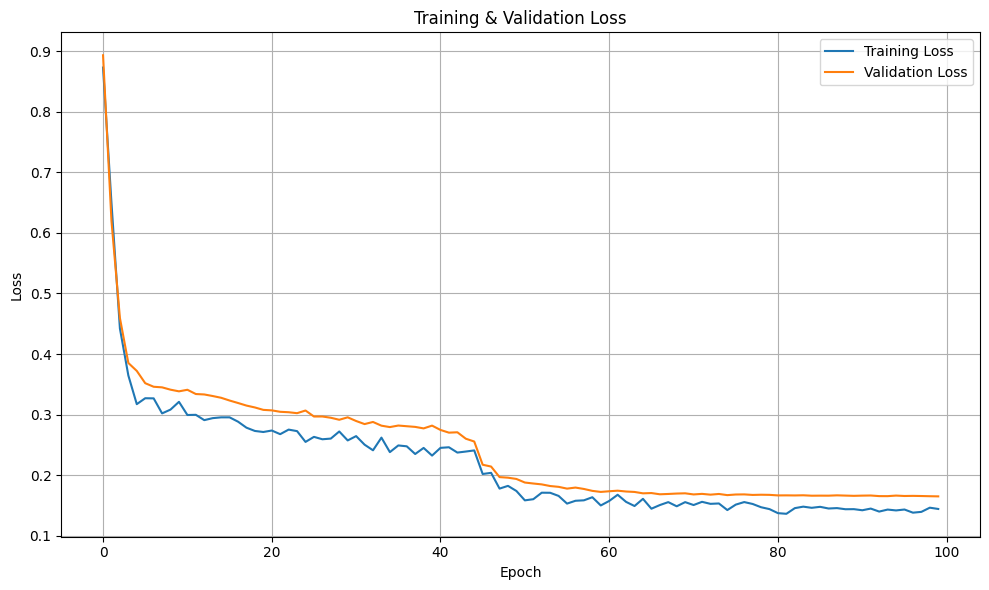

In [10]:
datamodule = ClimateDataModule(**config["data"])

specificModel = config["model"]["type"]

n_input_channels=len(config["data"]["input_vars"])
n_output_channels=len(config["data"]["output_vars"])


# model = SimpleCNN(
#     n_input_channels=len(config["data"]["input_vars"]),
#     n_output_channels=len(config["data"]["output_vars"]),
#     **{k: v for k, v in config["model"].items() if k != "type"}
# )

if(specificModel == "simple_cnn"):
    model = SimpleCNN(n_input_channels, n_output_channels, **{k: v for k, v in config["model"].items() if k != "type"})
elif(specificModel == "unet"):
    model = UNet(n_input_channels, n_output_channels, **{k: v for k, v in config["model"].items() if k != "type"})

lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

earlyStop = EarlyStopping(
    monitor="val/loss",
    patience=10,
    mode="min",
    verbose=True
)

goodModelCheckpoint = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints",
    monitor="val/loss",
    mode="min",
    save_top_k=1,
    filename="best-checkpoint",
)

trainer = pl.Trainer(
    callbacks=[earlyStop, goodModelCheckpoint],
    **config["trainer"]
)

# trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

plot_loss_curves(lightning_module.train_losses, lightning_module.val_losses)

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [11]:
best_model_path = goodModelCheckpoint.best_model_path
best_model = ClimateEmulationModule.load_from_checkpoint(
    best_model_path,
    model=model,  # Pass your model architecture again
    learning_rate=config["training"]["lr"],
)

best_model.normalizer = datamodule.normalizer

# Evaluate using the best model
trainer.test(best_model, datamodule=datamodule)
# trainer.test(lightning_module, datamodule=datamodule) 

Creating dataset with 2943 samples...
Creating dataset with 120 samples...
Creating dataset with 360 samples...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.0766, Time-Mean RMSE=290.0375, Time-Stddev MAE=3.5454
[TEST] pr: RMSE=4.1463, Time-Mean RMSE=3.6949, Time-Stddev MAE=1.3292
✅ Submission saved to: /kaggle/working/kaggle_submission_20250517_055459.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.146300792694092     │
│  test/pr/time_mean_rmse   │      3.6949303150177      │
│   test/pr/time_std_mae    │     1.329228401184082     │
│       test/tas/rmse       │     290.0765380859375     │
│  test/tas/time_mean_rmse  │     290.0374755859375     │
│   test/tas/time_std_mae   │     3.545407772064209     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.0765380859375,
  'test/tas/time_mean_rmse': 290.0374755859375,
  'test/tas/time_std_mae': 3.545407772064209,
  'test/pr/rmse': 4.146300792694092,
  'test/pr/time_mean_rmse': 3.6949303150177,
  'test/pr/time_std_mae': 1.329228401184082}]

### Plotting Utils


In [12]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


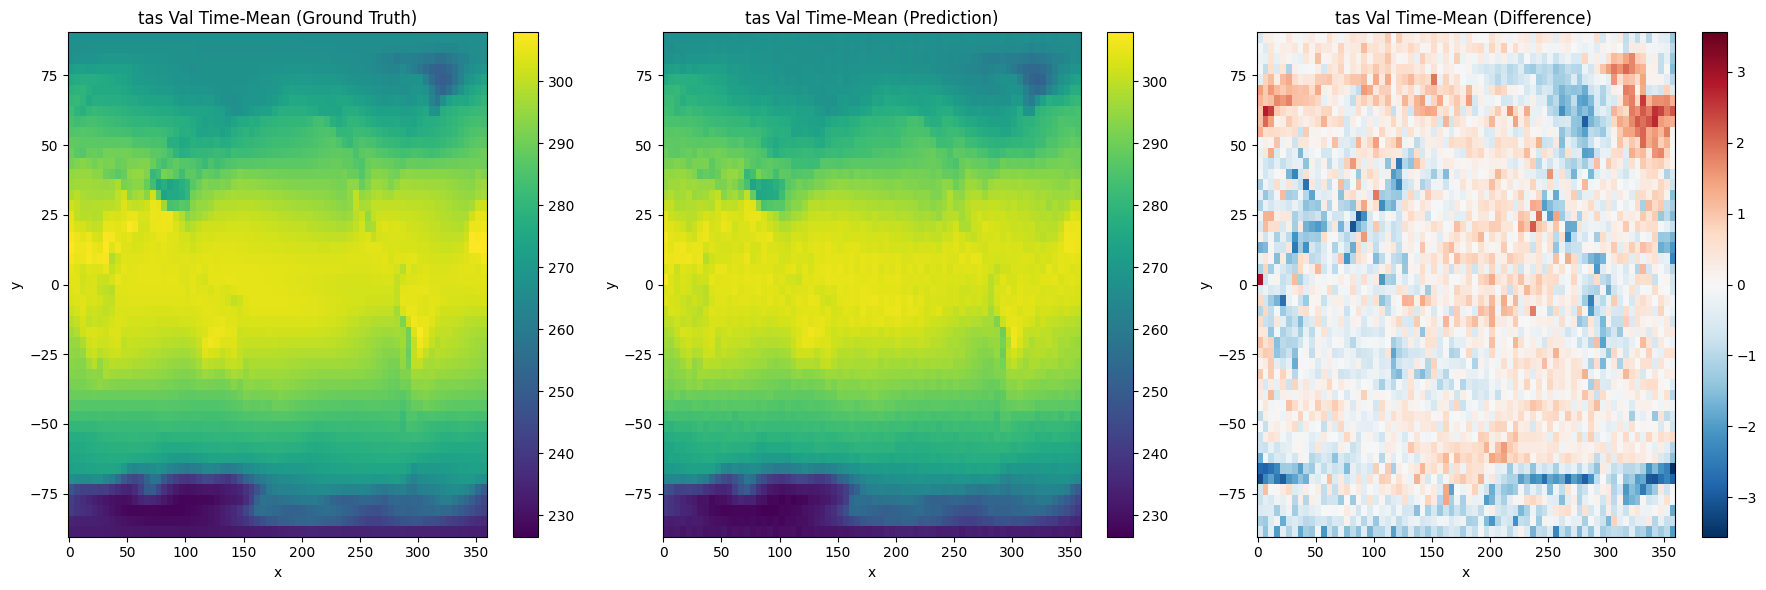

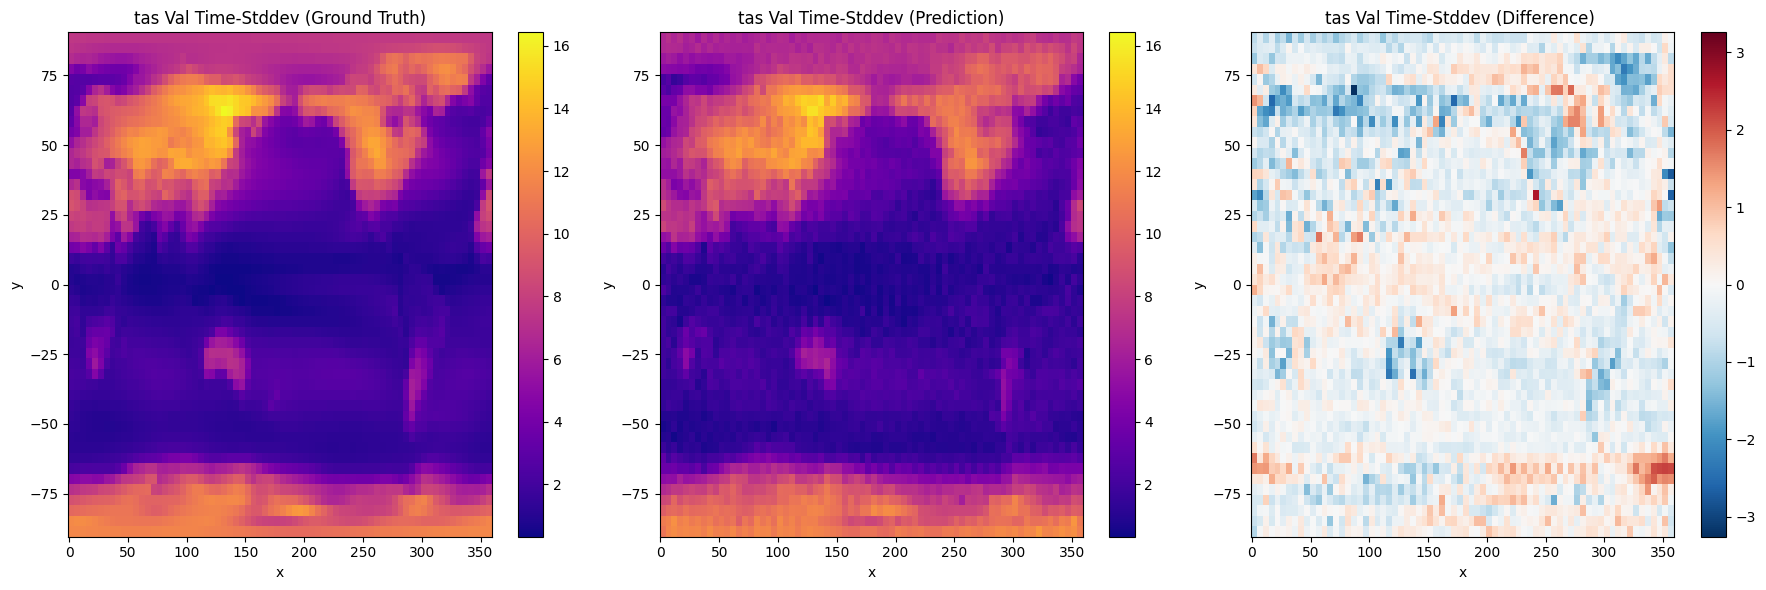

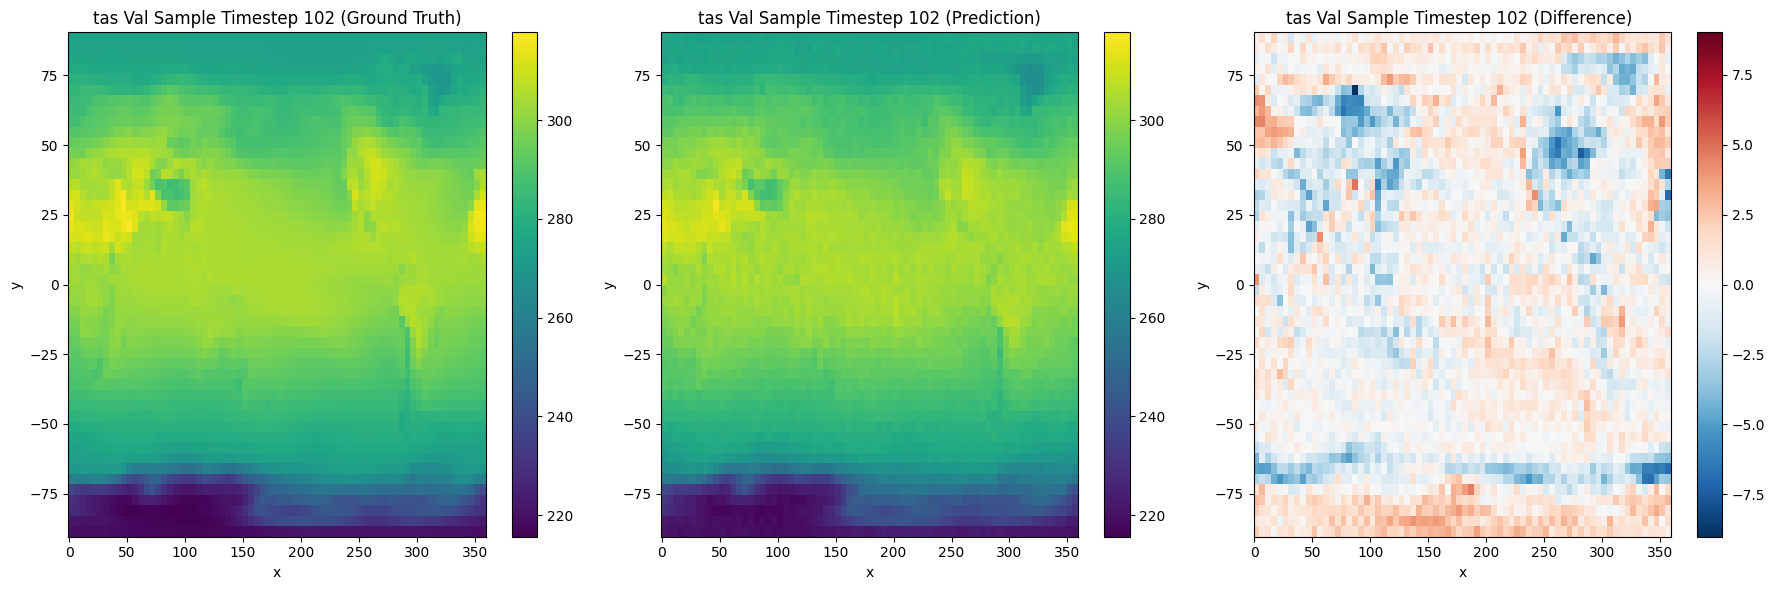

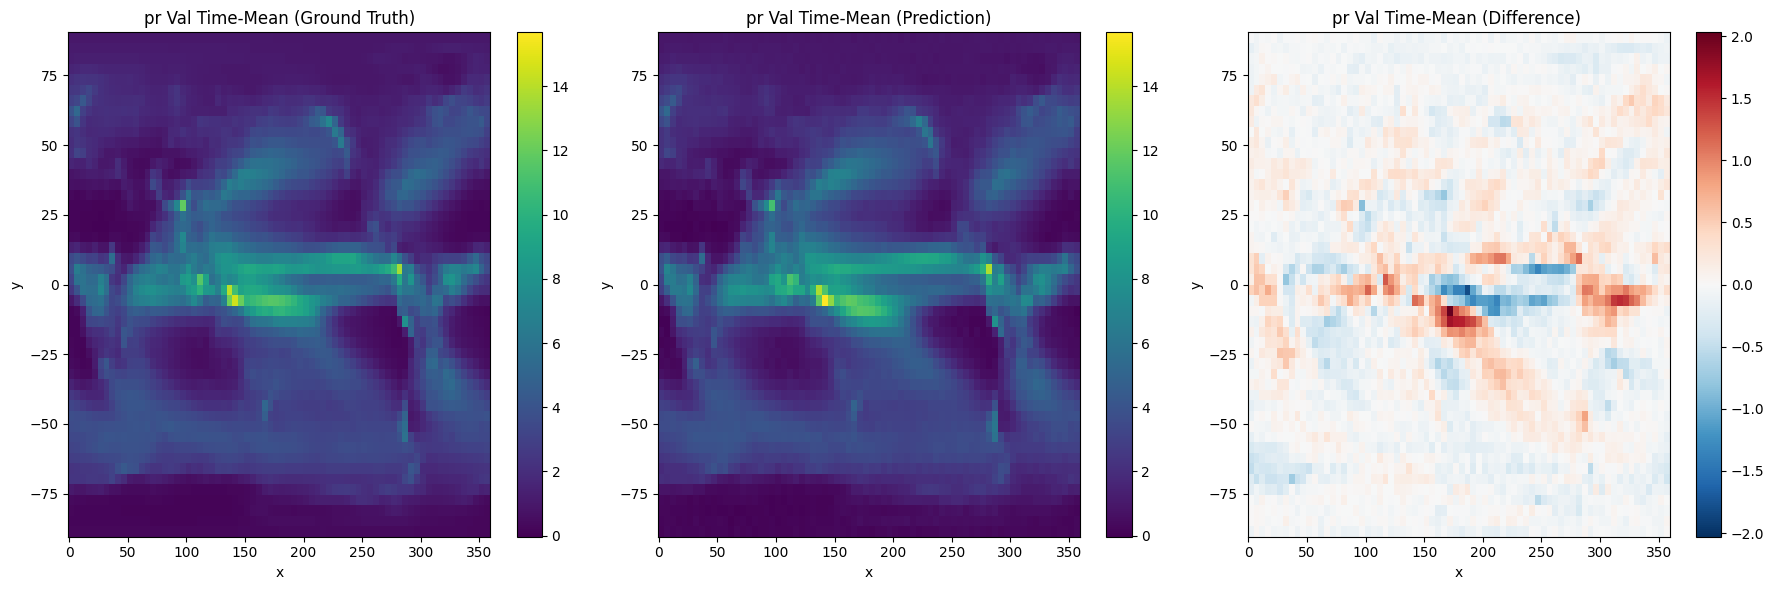

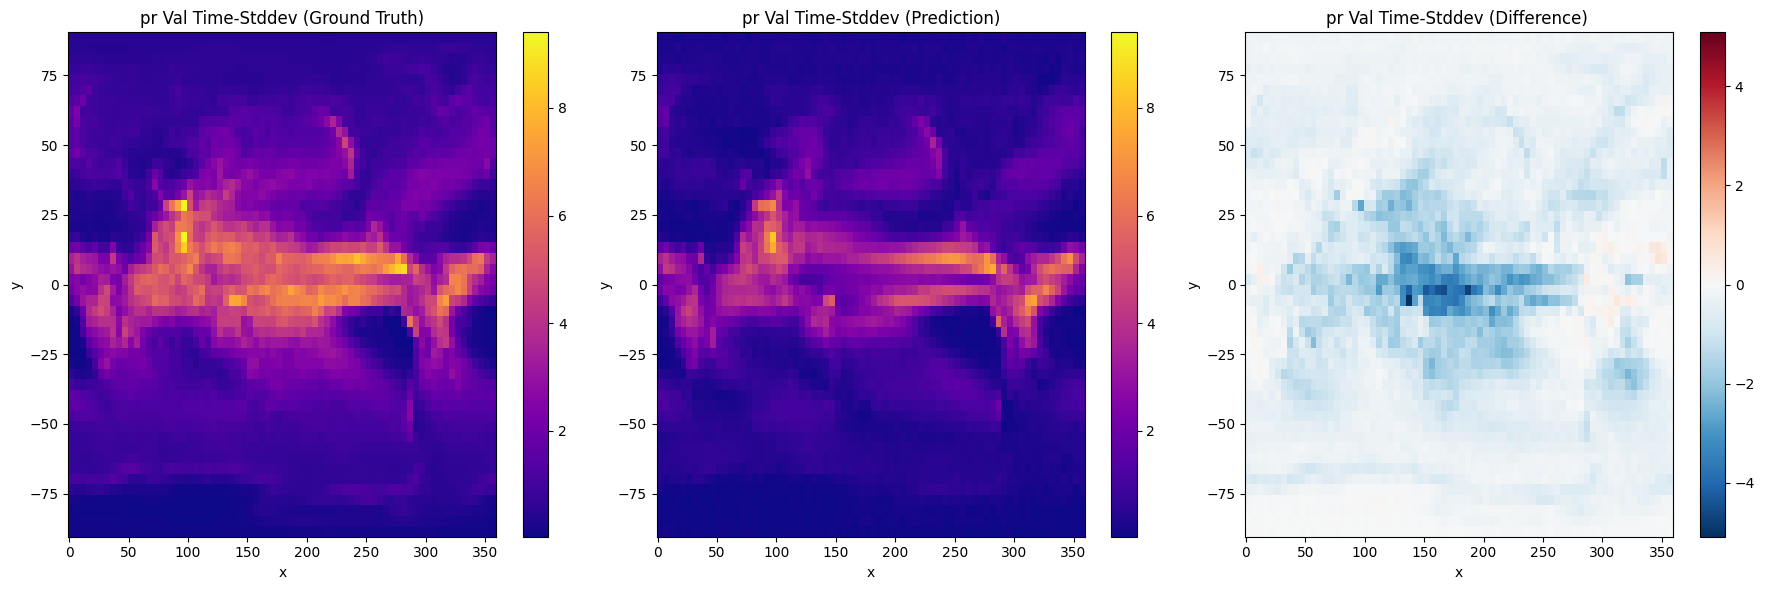

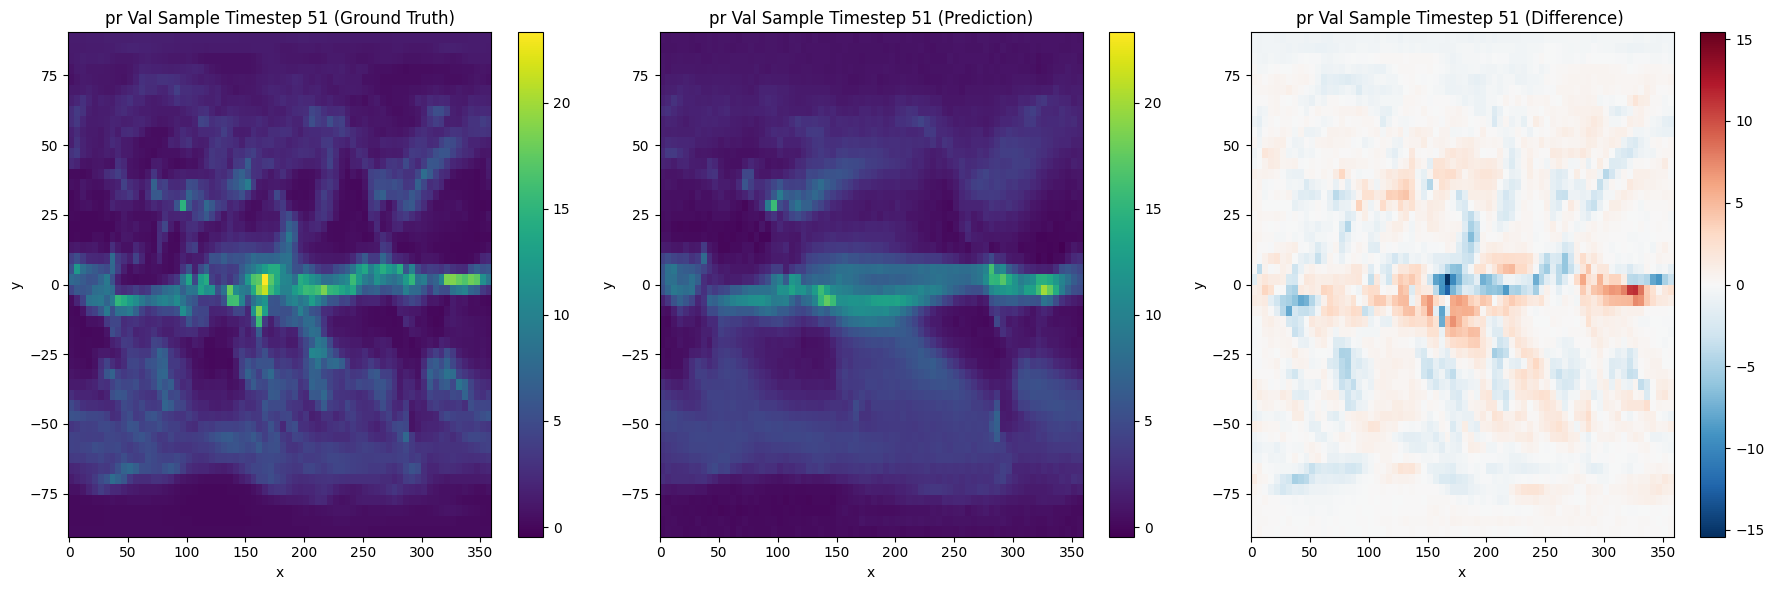

In [13]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")

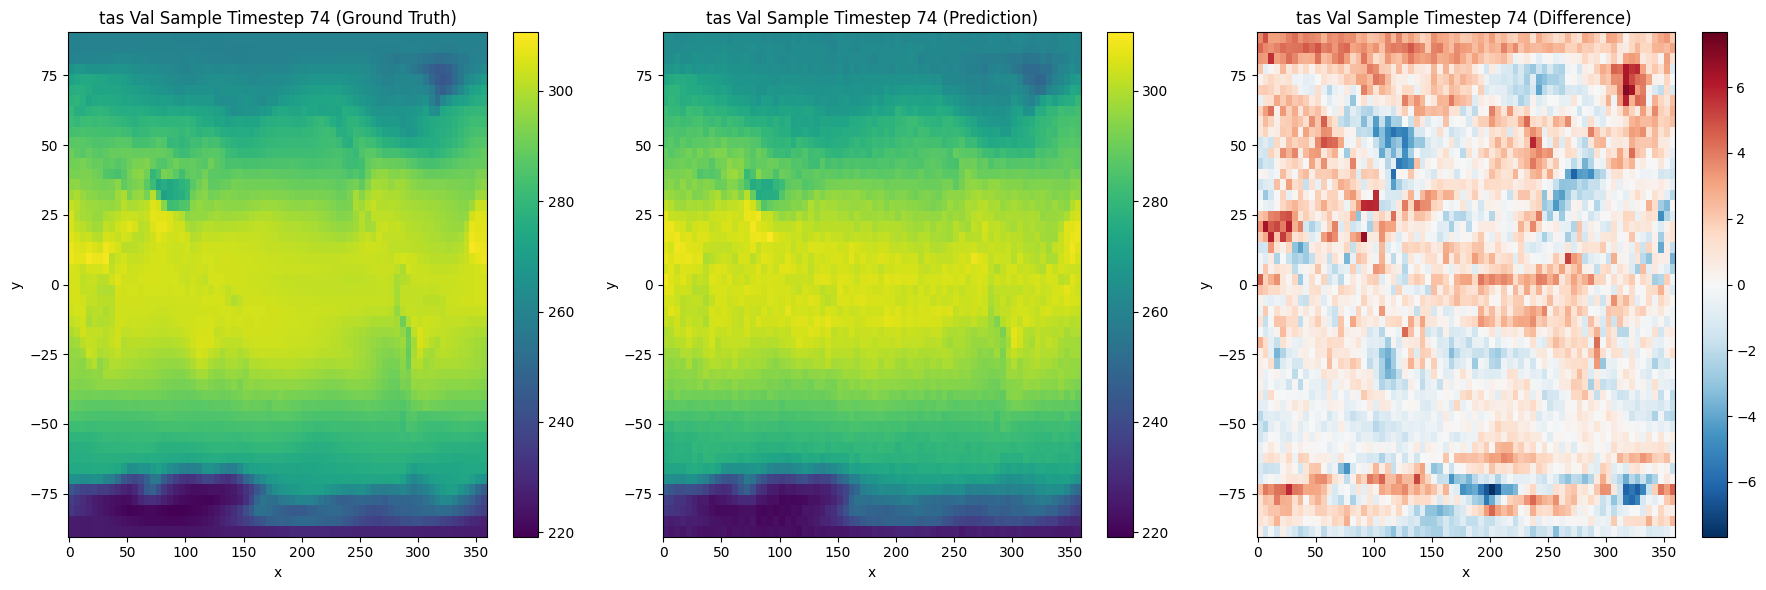

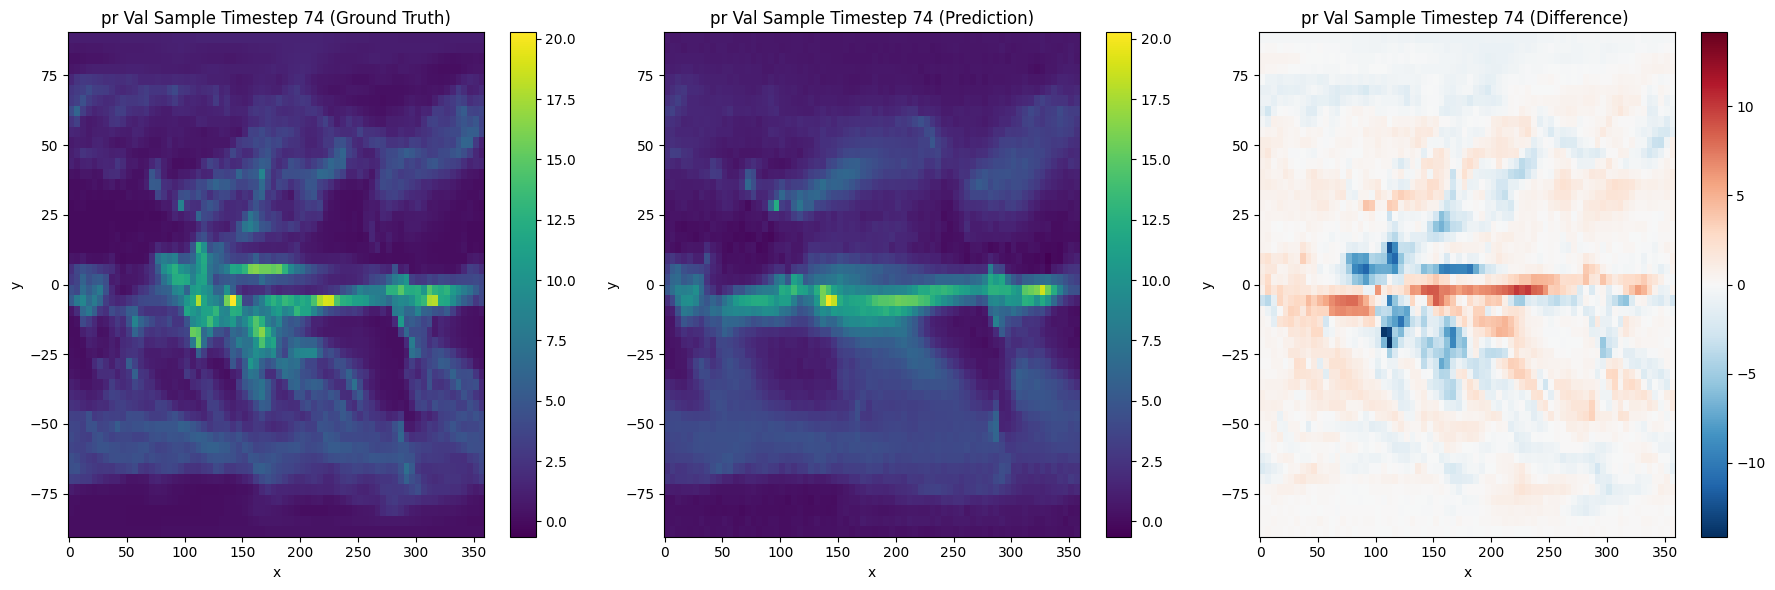

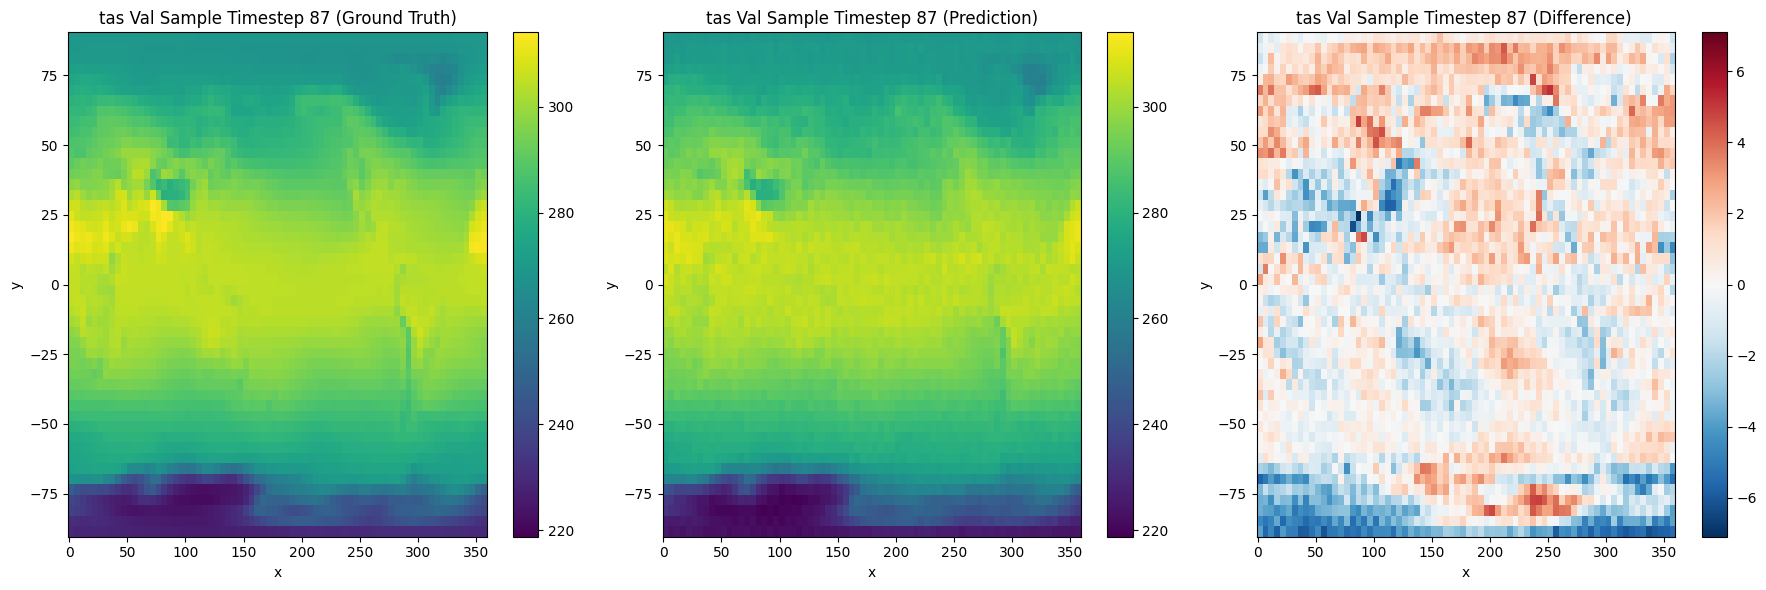

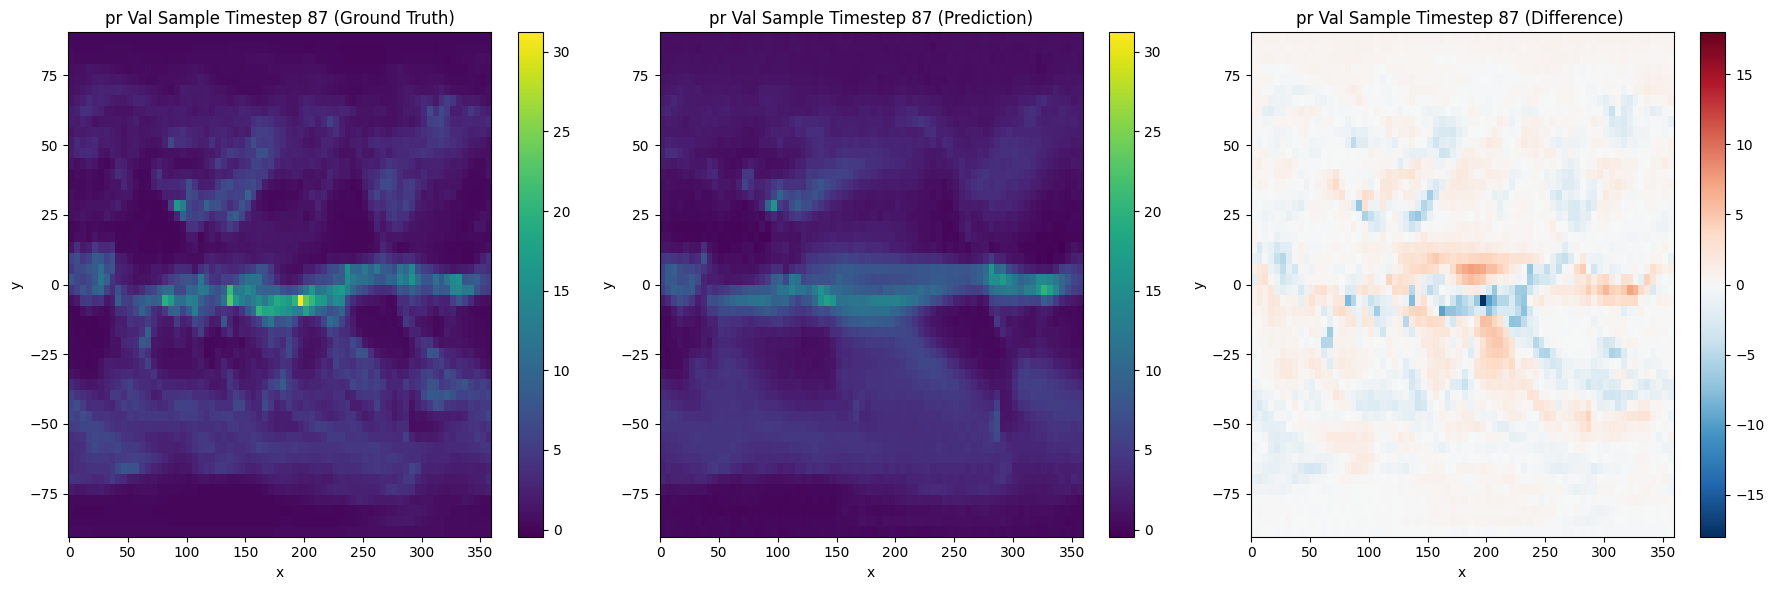

In [18]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

t_idx = np.random.randint(0, len(time))
for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")

t_idx = np.random.randint(0, len(time))
for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")

## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


tas (ssp126) → mean: 280.04, std: 21.09
tas (ssp370) → mean: 280.76, std: 20.88
tas (ssp585) → mean: 281.58, std: 20.71
pr (ssp126) → mean: 2.51, std: 2.69
pr (ssp370) → mean: 2.51, std: 2.67
pr (ssp585) → mean: 2.56, std: 2.76


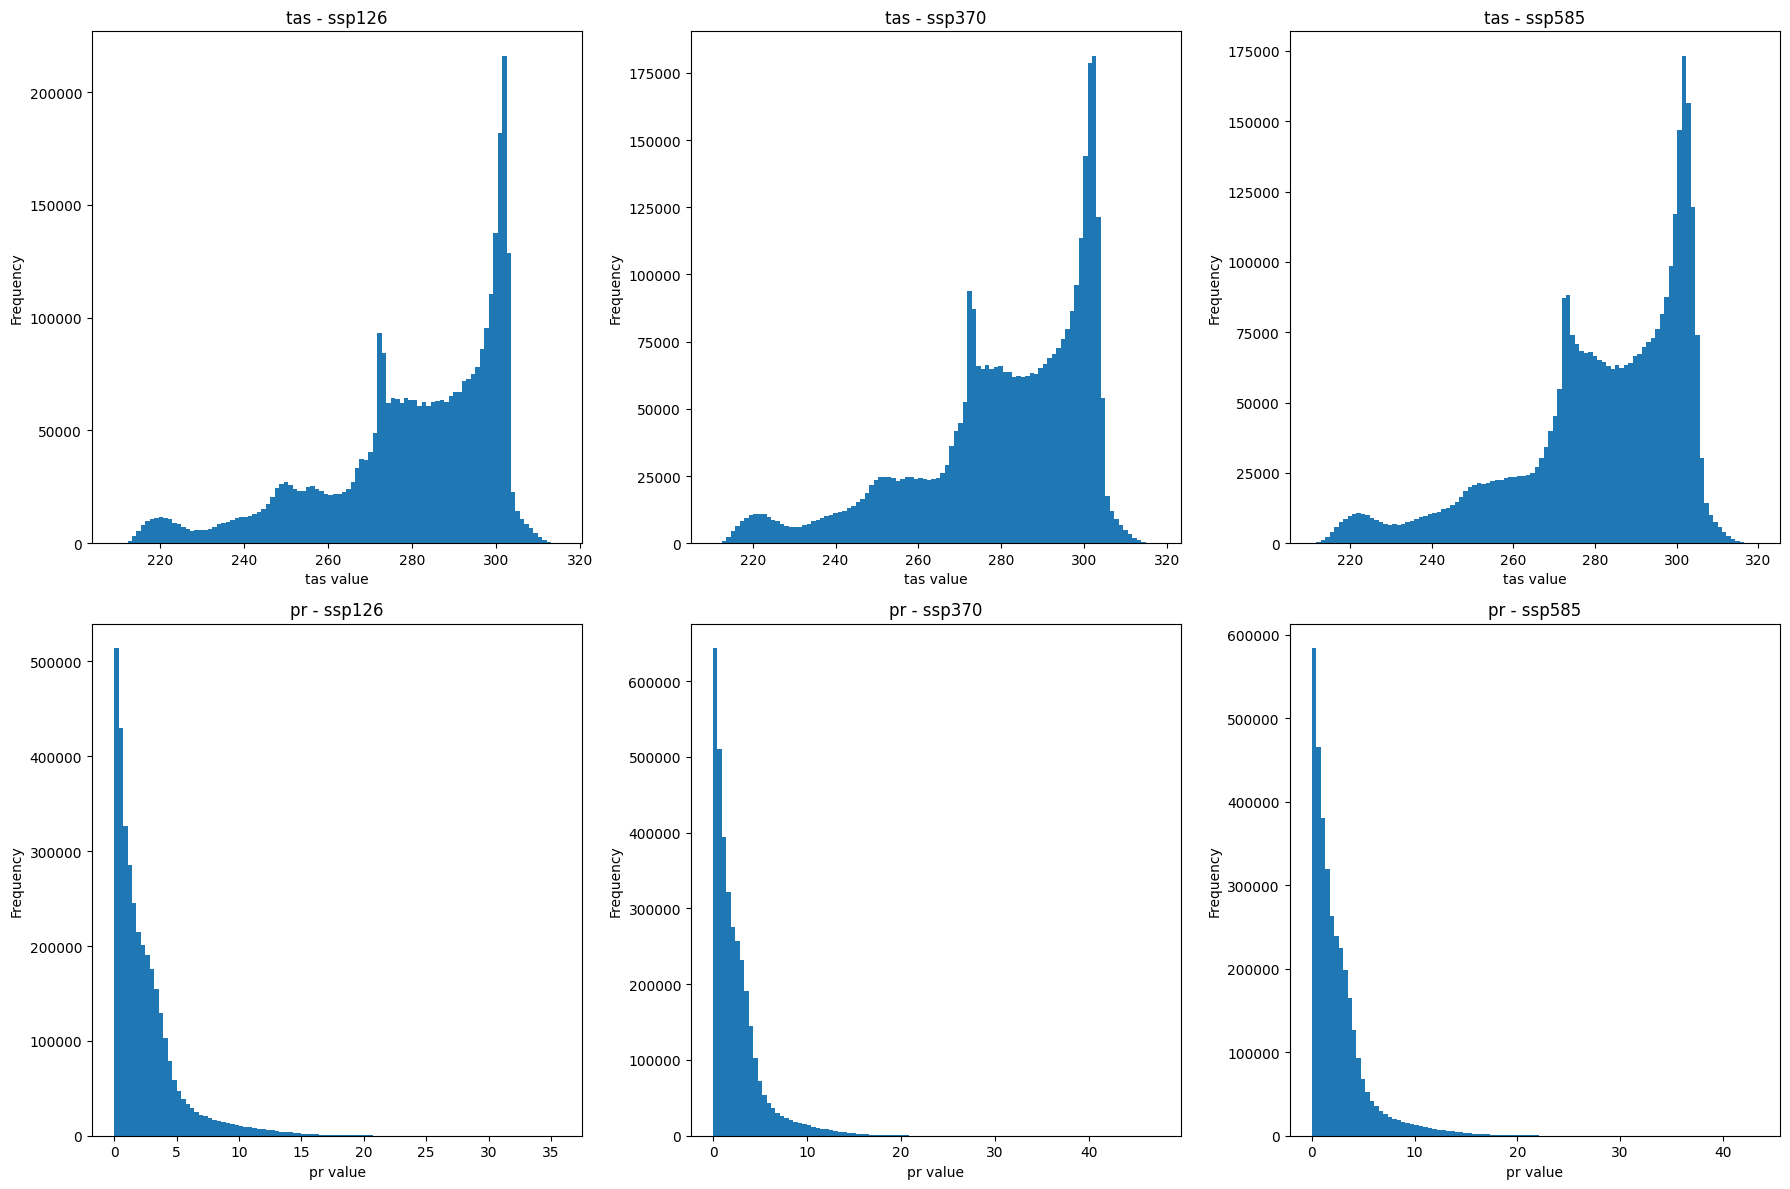

In [14]:
data_path = config["data"]["path"]
data = xr.open_zarr(data_path)

# Select relevant SSPs and average over ensemble members
# Set up 2 rows (variables) x 3 columns (SSPs)

ssps = ["ssp126", "ssp370", "ssp585"]
subset = data.sel(ssp=ssps).mean(dim=["member_id"])

target_vars = ["tas", "pr"]

fig, ax = plt.subplots(len(target_vars), len(ssps), figsize=(18, 12))

for i, var in enumerate(target_vars):
    for j, ssp in enumerate(ssps):
        vals = subset[var].sel(ssp=ssp).values.flatten()
        ax[i, j].hist(vals, bins=100)
        ax[i, j].set_title(f"{var} - {ssp}")
        ax[i, j].set_xlabel(f"{var} value")
        ax[i, j].set_ylabel("Frequency")

        mean_val = np.nanmean(vals)
        std_val = np.nanstd(vals)
        print(f"{var} ({ssp}) → mean: {mean_val:.2f}, std: {std_val:.2f}")

plt.tight_layout()
plt.show()

CO2 (ssp126) → mean: 2532.32, std: 401.70
CO2 (ssp370) → mean: 3874.43, std: 1528.99
CO2 (ssp585) → mean: 4653.01, std: 2343.88
CH4 (ssp126) → mean: 0.20, std: 0.07
CH4 (ssp370) → mean: 0.57, std: 0.11
CH4 (ssp585) → mean: 0.51, std: 0.07
rsdt (ssp126) → mean: 297.65, std: 164.09
rsdt (ssp370) → mean: 297.65, std: 164.09
rsdt (ssp585) → mean: 297.65, std: 164.09


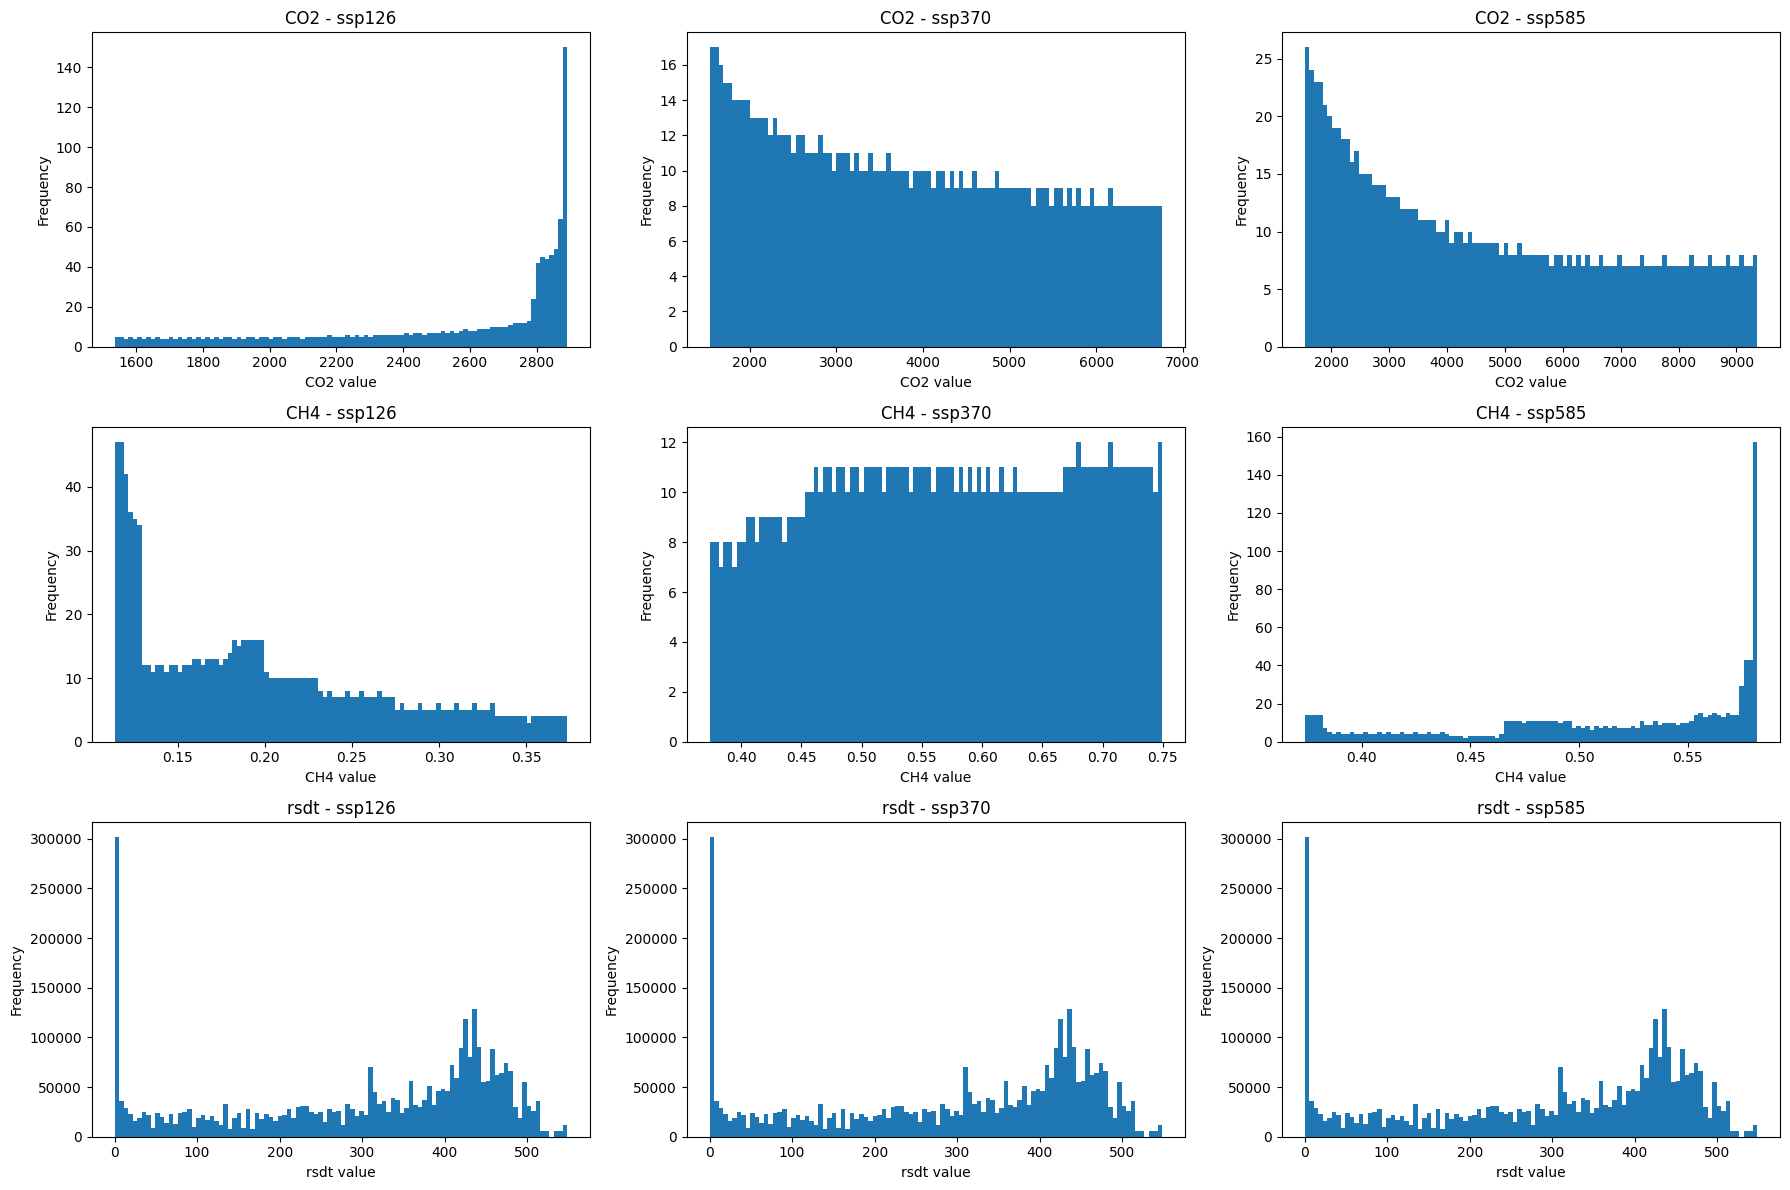

In [15]:
ssps = ["ssp126", "ssp370", "ssp585"]
subset = data.sel(ssp=ssps).mean(dim=["member_id"])

chosen_vars = ["CO2", "CH4", "rsdt"]

fig, axs = plt.subplots(len(chosen_vars), len(ssps), figsize=(18, 12))

for i, var in enumerate(chosen_vars):
    for j, ssp in enumerate(ssps):
        vals = subset[var].sel(ssp=ssp).values.flatten()
        axs[i, j].hist(vals, bins=100)
        axs[i, j].set_title(f"{var} - {ssp}")
        axs[i, j].set_xlabel(f"{var} value")
        axs[i, j].set_ylabel("Frequency")

        mean_val = np.nanmean(vals)
        std_val = np.nanstd(vals)
        print(f"{var} ({ssp}) → mean: {mean_val:.2f}, std: {std_val:.2f}")

plt.tight_layout()
plt.show()